=== GENERAL TODO'S:
                                       -|=======|=======|+
* Data read                                     ?
    * ~~Static~~                                        [done]
    * ~~Refrred to dicom fields~~                       [done]
    * Dynamic                                           [done]
        * interpolable                                  [done]
            * optimalization            [optional]
            * bicubic                   [optional]        
* Patchification system                         ?
    * ~~Static~~                                        [done]
    * Update-able                               [wip]
* Vascular segmentation                         [wip]
    * Linear kernel application                 [wip]
    * Canny                             [concept]
    * Canny -> Hull                     [concept]
    * Hull -> Mask                      [concept]
    * Mask -> Skel                      [concept]
    + CNN?                              [reluctant]
* Vascular positioning                          ?
    * Vascular skel model               [concept]
    * Vascular skel discrimination      [concept]
    * Characteristic points estim       [concept]
* Visualisation
    * ~~Mango-like~~                                    [done]
        * Efficient                     [concept]
    * Rotable                           [concept]

python3 -m pip install cupy-cuda110


tdsp = r"../AngioCT tt szyjnych/4/AQWS01_10.7.112.230_20220525111102552/1.3.12.2.1107.5.1.4.105397.30000021102806505454700023291/1.3.12.2.1107.5.1.4.105397.30000021102806505454700023292.dcm"

In [1]:
## IMPORTS
import pydicom
import matplotlib.pyplot as plt
import glob
# import re
# import os
# import patchify
from tqdm import tqdm
import cv2
import datetime

import numpy as np
import cupy as cp

na                  = np.asarray
xm = {
    np:             (np.asarray, np.asarray, np.asarray, np),
    cp:             (cp.asarray, cp.asnumpy, cp.asarray, cp),
}  # (da, ha, xa, xp)
xdarray2xp          = lambda xdarray: {np.ndarray: np, cp.ndarray: cp}[type(xdarray)]

AXALL, AXNEW = ((slice(None),), (None,))

ceil = lambda x: int(x) + (int(x) != x)

In [2]:
## DATA READ - BASIC
tdsp = r"../AngioCT tt szyjnych/4/AQWS01_10.7.112.230_20220525111102552/1.3.12.2.1107.5.1.4.105397.30000021102806505454700023291/*"
ds_path_l = glob.glob(tdsp)

ds_l = [pydicom.dcmread(ds_path) for ds_path in ds_path_l]
dsa  = na([ds.pixel_array for ds in ds_l[::-1]])

# for ds in ds_l: print(ds.AcquisitionTime)

# https://pydicom.github.io/pydicom/stable/auto_examples/image_processing/reslice.html#sphx-glr-auto-examples-image-processing-reslice-py
ds = ds_l[2]
ds.dir

## Image plane
# (0018, 0050) Slice Thickness                     DS: '0.6'                                            # [mm]                  Nominal slice thickness.            # https://dicom.innolitics.com/ciods/ct-image/image-plane/00180050
# (0020, 1041) Slice Location                      DS: '-28.5'+                                         # [mm] cz               
# (0028, 0030) Pixel Spacing                       DS: [0.416015625, 0.416015625]                       # [mm] *s(x, y)         (intuitive),                        # https://dicom.innolitics.com/ciods/ct-image/image-plane/00280030        
# (0020, 0032) Image Position (Patient)            DS: [-98.2919921875, -270.2919921875, -28.5]         # [mm]                  first image upper left corner       # https://dicom.innolitics.com/ciods/ct-image/image-plane/00200032
# (0020, 0037) Image Orientation (Patient)         DS: [1, 0, 0, 
#                                                       0, 1, 0]                                        # s2c(x, y, z) *s(x, y) projection mx cosines               # https://dicom.innolitics.com/ciods/ct-image/image-plane/00200037

##
# (0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
# (0018, 9313) Data Collection Center (Patient)    FD: [0.0, -164.0, -28.5]
# (0018, 9318) Reconstruction Target Center (Patie FD: [8.0, -164.0, -28.5]
# (0028, 1050) Window Center                       DS: [105, 250]
# (0028, 1051) Window Width                        DS: [765, 500]
# (0028, 1052) Rescale Intercept                   DS: '-1024.0'
# (0028, 1053) Rescale Slope                       DS: '1.0'

## Time
# (0008, 0032) Acquisition Time                    TM: '111515.611000'


<bound method Dataset.dir of Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.840.1.113669.632.21.1635916553.279322404.391980493922060650
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 2.16.840.1.113669.632.21.1
(0002, 0013) Implementation Version Name         SH: 'AQNET430-370IB5'
(0002, 0016) Source Application Entity Title     AE: ''
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID         

In [3]:
## CODE > PATCHIFY
na = np.asarray

def pad_patchify(
        input_array: np.ndarray,                                ##(*bdim, *pdim) 
        padded_patch_shape,                                     ##(             pdim)
        pad_shape,                                              ##({shu+shr},   pdim)
        input_crop_shape,                                       ##({shu+shr},   pdim)
        patch_excess_min,                                       ##(             pdim)
        pad_mode="edge",                                        # numpy.pad(mode=)
        tv = None,                                           # str
):
    pdim    = padded_patch_shape.__len__()                      # patch dimensions no
    bdim    = input_array.shape.__len__() - pdim                # batch dimensions no

    ## calc actual lower padding (not being covered by crop margin)
    pad_shl,  pad_shr   = na(pad_shape)                         # shl, shu, shr = shape [span] lower, upper, rearwards
    crop_shl, crop_shr  = na(input_crop_shape)        
    arr2opa_shl         = crop_shl - pad_shl                    # position of opa's i0 relative to array (consider it vec); opa = outer-padded array
    opa2arr_shl         = pad_shl - crop_shl                    # postition of array's i0 relative to opa
    arr_crop_shl        = np.maximum(0, arr2opa_shl)            # reduce input cropping if no enough crop to satisfy padding
    opa_pad_shl         = np.maximum(0, opa2arr_shl)            # pad needing artificial fulfilling as not being covered by cropped image

    ## calc how much patches will be there  
    array_sh            = na(input_array.shape[ bdim:])
    crarr_sh            = array_sh - (crop_shl + crop_shr)      # crarr = cropped_array
    pdp_sh              = na(padded_patch_shape)                # pdp = padded_patch
    upd_sh              = pdp_sh - (pad_shl+pad_shr)            # upd = unpadded[_patch]
    patch_step          = upd_sh                                # step between 0th elements of consecutive patches
    upd_ex_min_sh       = na(patch_excess_min)
    pgrid_sh, pex_rm_sh = np.divmod(crarr_sh, patch_step)
    pex_accept          = pex_rm_sh >= upd_ex_min_sh
    pgrid_sh            = pgrid_sh + pex_accept

    ## calc opa upper padding
    opa_sh              = (pgrid_sh * upd_sh) + (pad_shl + pad_shr)
    arr2opa_shu         = arr2opa_shl + opa_sh 
    opa2arr_shu         = opa2arr_shl + array_sh
    arr_crop_shu        = np.minimum(array_sh, arr2opa_shu)
    opa_pad_shu         = np.minimum(opa_sh,   opa2arr_shu)
    opa_pad_shr         = opa_sh - opa_pad_shu

    ## quick checks
    assert np.all(upd_sh > 0)                                   # is patch containing anything beside patch
    assert np.all(upd_ex_min_sh <= upd_sh)                      # is patch_excess_min positive
    assert np.all(pgrid_sh > 0)                                 # is possible to create at least one patch (by input shape, patch shape, patch excess)

    ## opa = input crop & outer-pad
    batch_sh            = na(input_array.shape[:bdim ])
    batch_all           = (slice(None),)    *bdim
    batch_pad           = (0,)              *bdim
    input_crop          = tuple(slice(aclx, acux)   for aclx, acux in zip(arr_crop_shl, arr_crop_shu))
    opa                 = np.pad(
                                        input_array[batch_all + input_crop], 
                            pad_width=  na((
                                            batch_pad + tuple(opa_pad_shl), 
                                            batch_pad + tuple(opa_pad_shr))).T, 
                            mode=       pad_mode) # type: ignore
    
    ## patchify
    patch_array         = np.zeros(())
    pgrid_og            = np.ogrid[tuple(slice(pgsx) for pgsx in pgrid_sh)]
    patch_og            = np.ogrid[tuple(slice(pasx) for pasx in pdp_sh)]
    pg2pa_og            = tuple(
                                (pgogx * pstepx)[(slice(None),) *pdim   + (None,)           *pdim] 
                            +   paogx           [(None,)        *pdim   + (slice(None),)    *pdim] 
                            for     pgogx,      pstepx,     paogx 
                            in zip( pgrid_og,   patch_step, patch_og))
    
    for _ in tqdm((None,), desc=f"{tv} [PBX={pgrid_sh.prod()}]", disable=not tv):
        patch_array     = opa[batch_all + pg2pa_og]

    ## save info about actual shape for merging
    pgrid_shape         = tuple(pgrid_sh)
    pex_crop_shr        = (upd_sh - pex_rm_sh) * pex_accept
    array_shape         = (pgrid_sh * upd_sh) - pex_crop_shr

    return patch_array, pgrid_shape, array_shape

def pad_unpatchify(
        patch_array: np.ndarray,
        padded_patch_shape,
        pad_shape,
        array_shape,
        tv = None
):
    pdim                = padded_patch_shape.__len__()
    bdim                = patch_array.shape.__len__() - (pdim *2)

    ## calc pads
    pdp_sh              = na(padded_patch_shape)
    pad_shl,  pad_shr   = na(pad_shape)
    upd_sh              = pdp_sh - (pad_shl+pad_shr)
    patch_step          = upd_sh

    pad_shu             = pdp_sh - pad_shr
    pgrid_shape         = patch_array.shape[bdim:-pdim]
    pgrid_sh            = na(pgrid_shape)

    ## unpatchify
    batch_shape         = patch_array.shape[:bdim ]
    batch_all           = (slice(None),) *bdim
    unpad_crop          = (slice(None),) *pdim + tuple(slice(pshlx, pshux) for pshlx, pshux in zip(pad_shl, pad_shu))
    pgrid_og            = np.ogrid[tuple(slice(pgsx) for pgsx in pgrid_sh)]
    patch_og            = np.ogrid[tuple(slice(pasx) for pasx in upd_sh)]
    pg2pa_og            = tuple(
                                (pgogx * pstepx)[(slice(None),) *pdim   + (None,)           *pdim] 
                            +   paogx           [(None,)        *pdim   + (slice(None),)    *pdim] 
                            for     pgogx,      pstepx,     paogx 
                            in zip( pgrid_og,   patch_step, patch_og))

    ## merge
    output_array_ex_sh  = pgrid_sh * upd_sh
    output_array_ex     = np.zeros((*batch_shape, *output_array_ex_sh), dtype=patch_array.dtype)

    for _ in tqdm((None,), desc=f"{tv} [PBX={pgrid_sh.prod()}]", disable=not tv):
        output_array_ex[batch_all + pg2pa_og] = patch_array[batch_all + unpad_crop]

    ## discard excess
    output_array_sh     = array_shape
    output_array        = output_array_ex[(...,) + tuple(slice(osx) for osx in output_array_sh)]

    return output_array

def batchify(
        pbatch_iter,                                            ##(bdim*p[g]dim, pdim)
        patch_shape,                                            ##(pdim)
        umem_pool,                                                # bytes / type.nbytes
        umem_poly,                                               # (1, root(pdim, mlt(patch_sh)), root(pdim, mlt(patch_sh)**2), ..., ) | %todo
        tv=None,
        xp=np,
):
    ## batch_size calc
    pdim                = patch_shape.__len__()
    umem_poly           = na(umem_poly)

    if  umem_poly.shape.__len__() == 1:                     # convert linear polynomial to dimensional one
        umem_poly_lin       = umem_poly
        umem_poly_lin_l     = umem_poly_lin.__len__()
        umem_poly_shx       = int(np.ceil((umem_poly_lin_l-1)/pdim) + 1)
        umem_poly_lin_lp    = (umem_poly_shx * pdim) - pdim + 1
        umem_poly_lin       = np.pad(umem_poly_lin, 
                                (0, umem_poly_lin_lp - umem_poly_lin_l), 
                                "constant", constant_values=0) # type: ignore
        umem_poly_map       = np.mgrid[(slice(umem_poly_shx),) *pdim].sum(axis=0)
        umem_poly           = umem_poly_lin[umem_poly_map]
        patch_shape         = (np.prod(patch_shape) **(1/pdim),) *pdim
    assert  umem_poly.shape.__len__() ==  pdim

    umem_deters         = np.multiply.reduce(na(tuple(
                            np.power(   pshx,           pogx) 
                            for         pshx,           pogx 
                            in zip(     patch_shape,    np.ogrid[tuple(slice(ups) for ups in umem_poly.shape)])),
                            dtype=object))
    umem_estim          = (umem_poly * umem_deters).sum()
    batch_size          = int(umem_pool // umem_estim)
    if not batch_size > 0:
        print(umem_pool/umem_estim)
    assert batch_size > 0

    ## batchify iterations
    # iters_nd            = xp.fromiter(pbatch_iter, dtype=int)
    iters_nd            = xp.asarray(list(pbatch_iter))
    iters_l             = iters_nd.__len__()
    iters_gen           = [((bind.__len__(),), tuple(bind.T))
                            for bix in range(0, iters_l, batch_size)
                            for bind in (iters_nd[bix:(bix+batch_size)],)]
    iters_tq            = tqdm(iters_gen, desc=f"{tv} [PBX={batch_size}/{iters_l}]", disable=not tv)
    return iters_tq
    

In [4]:
## DEFINE > LINEAR KERNELS

na = np.asarray

zero_kenrel = na([
    [[ 0,  0,  0], [ 0,  0,  0], [ 0,  0,  0]],
    [[ 0,  0,  0], [ 0,  0,  0], [ 0,  0,  0]],
    [[ 0,  0,  0], [ 0,  0,  0], [ 0,  0,  0]],

])

# X- Z| Y\
sobel_kernel3_gen = na([
    [[-1, -2, -1], [-2, -4, -2], [-1, -2, -1]],
    [[ 0,  0,  0], [ 0,  0,  0], [ 0,  0,  0]],
    [[+1, +2, +1], [+2, +4, +2], [+1, +2, +1]],
])
sobel_kernel3s = (
    sobel_kernel3_gen.swapaxes(0, 2), #z
    sobel_kernel3_gen.swapaxes(0, 1), #y
    sobel_kernel3_gen, #x
)[::-1] # (iAxis<kernel>, kZ, kY, kX)

sharpen_kernel3_gen = na([
    # [[ 0,  0,  0], [ 0,  0,  0], [ 0,  0,  0]],
    [[ 0, -1,  0], [-1,  5, -1], [ 0, -1,  0]],
    # [[ 0,  0,  0], [ 0,  0,  0], [ 0,  0,  0]],
])
sharpen_kernel3s = (
    sharpen_kernel3_gen,
    sharpen_kernel3_gen.swapaxes(0, 1),
    sharpen_kernel3_gen.swapaxes(0, 2),
)

sharpen_kernel3d3 = na([
    [[ 0,  0,  0], [ 0, -1,  0], [ 0,  0,  0]],
    [[ 0, -1,  0], [-1,  7, -1], [ 0, -1,  0]],
    [[ 0,  0,  0], [ 0, -1,  0], [ 0,  0,  0]],
])

In [5]:
## CODE > KERNEL APPLY
import cupy as cp
xd, xh, xa, xp          = xm[cp]  

def kernel_apply(patch_pd_shape_in, kernel, kernel_center=None):
    kernel_shape        = kernel.shape
    kernel_center       = kernel_center if kernel_center is not None else tuple((kshx-1)//2 for kshx in kernel_shape)
    assert patch_pd_shape_in.__len__() == kernel_shape.__len__()
    assert all(0 <= kcxx and kcxx < kshx for kcxx, kshx in zip(kernel_center, kernel_shape))

    pad_shape_io        = (
        tuple(kcx           for _,   kcx    in zip(kernel_shape, kernel_center)), 
        tuple((ksx-1)-kcx   for ksx, kcx    in zip(kernel_shape, kernel_center)))

    if (pad_shape_in:=None) is not None: 
        raise NotImplementedError
    else:
        kernel_adjust   = (0,) *kernel_shape.__len__()
        pad_shape_op    = ((0,) *kernel_shape.__len__(),)*2

    patch_pd_shape_op      = tuple(
        patch_shx - (pad_shxl + pad_shul)                      
            for patch_shx, pad_shxl, pad_shul in zip(patch_pd_shape_in, *pad_shape_io))    # unpadded preferably
        
    ixt_gen = tuple((
        kernel_ixt,                                                                                                             # kernel_mask
        tuple(slice(kix + kadjx, asx + kix + kadjx) for kix, asx, kadjx in zip(kernel_ixt, patch_pd_shape_op, kernel_adjust)),  # patch_mask
        ) for kernel_ixt in xp.ndindex(kernel_shape) if kernel[kernel_ixt] != 0
    )
    
    return patch_pd_shape_op, pad_shape_op, ixt_gen

def _kernel_apply2_iter(pgrid_shape, dtype, xp, ixt_gen, patch_pd_shape_op):
    patch_op = xp.zeros((*pgrid_shape, *patch_pd_shape_op), dtype=dtype)
    for ixt_gen_op in ixt_gen: yield (*ixt_gen_op, patch_op)

def kernel_apply2(patch_pd_shape_in, kernel, kernel_center=None, dtype=None):
    patch_pd_shape_op, pad_shape_op, ixt_gen = kernel_apply(patch_pd_shape_in, kernel, kernel_center)
    return patch_pd_shape_op, pad_shape_op, lambda pgrid_shape=(): _kernel_apply2_iter(pgrid_shape, dtype, xdarray2xp(kernel), ixt_gen, patch_pd_shape_op)

dsa                     = dsa # unmussolinize image
# dsa                 = dsa[tuple(slice(psx) for psx in patch_shape)]  # test# i := int(1e3) and dsa := np.zeros(i**3).reshape((i,)*3) # test

proc_dtype              = np.float16
dsa                     = dsa.astype(proc_dtype)
kernel                  = sobel_kernel3s[2].astype(proc_dtype)

kbim                    = 3 # kernel batch dimension
pdim                    = 3
patch_pdshin            = (16, )    *pdim               # patch_padded_shape_in
pad_shape_in            = ((1,  )    *pdim,) *2

kernel_sobel_d          = xd(sobel_kernel3s)
kernel_sharp_d          = xd(sharpen_kernel3d3)

dspdin, pgrid_shape, amerge_shape   \
                        = pad_patchify(dsa, patch_pdshin, pad_shape_in, ((0,)*3,)*2, (0,)*3, tv="patchify")

_osh                    = patch_pdshin
_osh, _psh, iter_sobel  = kernel_apply2(_osh, kernel_sobel_d[0], (1,)*pdim, xp.float32)
patch_pdshop            = _osh
pad_shape_op            = _psh
dspaop_amp_pl              = np.zeros((3, *pgrid_shape, *patch_pdshop), dtype=proc_dtype)  # dtype=dspain.dtype) # % todo: parametrize when input data signed
dspaop_arc_pl              = np.zeros((3, *pgrid_shape, *patch_pdshop), dtype=proc_dtype)  # dtype=dspain.dtype) # % todo: parametrize when input data signed

for bl, bix             in batchify(np.ndindex(pgrid_shape), patch_pdshin, 
                            2**31 //2, (*(0,)*pdim, 120), tv="linear kernel batchified seqencing"):
    patch_in_d          = xd(dspdin[bix])

    for kernel_ixt, patch_sxt, op_sobel in iter_sobel((*bl, kbim)): 
        op_sobel[:] +=  patch_in_d[(*AXALL, *AXNEW, *patch_sxt)]   * kernel_sobel_d[(*AXALL, *kernel_ixt, *AXNEW*3)]
    patch_op_amp     = xp.sqrt(((op_sobel[:, [[1,2], [0,2], [0,1]]]) **2).sum(axis=2)).astype(proc_dtype) # ZYX (as normals)
    patch_op_arc     = xp.arctan2(op_sobel[:, [2,0,1]], op_sobel[:, [1,2,0]]).astype(proc_dtype) # ZYX

    dspaop_amp_pl[(*AXALL, *bix,)] = xh(patch_op_amp.swapaxes(1, 0))
    dspaop_arc_pl[(*AXALL, *bix,)] = xh(patch_op_arc.swapaxes(1, 0))


dsa_amp_pl          = pad_unpatchify(dspaop_amp_pl, patch_pdshop, pad_shape_op, amerge_shape, tv="unpatchify") #= aom[:, 0]
dsa_arc_pl          = pad_unpatchify(dspaop_arc_pl, patch_pdshop, pad_shape_op, amerge_shape, tv="unpatchify") #= aom[:, 1]

patchify [PBX=56129]: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]
linear kernel batchified seqencing [PBX=2184/56129]: 100%|██████████| 26/26 [00:08<00:00,  2.98it/s]
unpatchify [PBX=56129]: 100%|██████████| 1/1 [00:04<00:00,  4.81s/it]


In [6]:
dsa.shape, dsa_amp_pl.shape, dspaop_amp_pl.shape

((563, 512, 512), (3, 563, 512, 512), (3, 41, 37, 37, 14, 14, 14))

In [19]:
## CODE > CIRCSEGM > INIT
proc_dtype  = xp.float16
index_dtype = xp.int16
radii_dtype = xp.float16
score_dtype = xp.float16
xd, xh, xa, xp = xm[cp]      
ndim=3       

mmclamm = 750
patch_upd_shx = 64

## V mm
cc_mask_stddev = 3
cc_mask_step = 3
cc_mask_threshold = .5
cc_score_cutoff = .5
cc_radii_cutoff = 5.1
cc_range = (3, 16, cc_mask_step)
ccrrl = list([1, 2]) + list(range(*cc_range))

mm_clamp = (mmclamm, mmclamm+100)
ccrrl = sorted(ccrrl)
assert any(crx < cc_radii_cutoff for crx in ccrrl)

pad_cc_radius = ceil(max(ccrrl) + (cc_mask_stddev*2))
pad_ms_radius = ceil(max(ccrrl))

patch_pad_sh = ((pad_cc_radius,) *ndim) *2
patch_pdd_sh = (patch_upd_shx + pad_cc_radius*2,) *ndim
patch_upd_sh = (patch_upd_shx,) *ndim 

nd_2d2z = (*AXNEW, *AXALL, *AXALL)
nd_rollaxes = tuple(tuple((idim+jdim)%ndim for idim in range(ndim)) for jdim in range(ndim))
nd_z2i = lambda z2i, idim: xdarray2xp(z2i).moveaxis(z2i, nd_rollaxes[0], nd_rollaxes[idim])

if True:
    sh_padded       = patch_pdd_sh
    sh_unpadd_nd    = tuple(tuple(na(sh_padded)          - (np.arange(ndim)   != idim)*2*pad_cc_radius) for idim in range(ndim))
    sh_mspadd_nd    = tuple(tuple(na(sh_unpadd_nd[idim]) + (np.arange(ndim)   != idim)*2*pad_ms_radius) for idim in range(ndim))
    sh_oppadd       = tuple(na(sh_padded)                - (np.ones(ndim)     ==1)    *2*pad_cc_radius)

    pad_ms      = tuple(tuple((0,)*2                                    if idim==jdim else (pad_ms_radius,)*2                   for jdim in range(ndim)) for idim in range(ndim))
    crop_ms     = tuple(tuple(slice(pad_cc_radius, -pad_cc_radius)      if idim==jdim else slice(None) for jdim in range(ndim)) for idim in range(ndim))
    pad_ms_mxa = xp.mgrid[(slice(-pad_ms_radius, pad_ms_radius+1),)*2].astype(index_dtype)
    pad_ms_amp = xp.sqrt((pad_ms_mxa.astype(radii_dtype)**2).sum(axis=0))
    pad_ms_mask = (pad_ms_amp <= pad_ms_radius) * (pad_ms_amp > 0)
    iter_adjmax_mask_nd = tuple(tuple(
            (nd_z2i(pad_ms_amp[nd_2d2z], idim)[kernel_ixt], patch_sxt) 
                for kernel_ixt, patch_sxt in kernel_apply(sh_mspadd_nd[idim], nd_z2i(pad_ms_mask[nd_2d2z], idim))[-1])
        for idim in range(ndim))

    pad_cc_mxa = xp.mgrid[(slice(-pad_cc_radius, pad_cc_radius+1),)*2].astype(index_dtype)
    pad_cc_amp = xp.sqrt((pad_cc_mxa.astype(radii_dtype)**2).sum(axis=0))
    # pad_cc_arc_nd = tuple(xp.arctan2(pad_cc_mxa[nd_rollaxes[idim][1]], pad_cc_mxa[nd_rollaxes[idim][0]]) for idim in range(ndim))
    pad_cc_arc = xp.arctan2(pad_cc_mxa[1], pad_cc_mxa[0])

circ_gen_zyx = []
for idim in range(ndim):
    circ_gen_i = []
    for ixcr, ccrr in enumerate(ccrrl):
        cc_mask_stddev = cc_mask_stddev 
        ccr_rim = ccrr
        cc_divs = ccr_rim*2

        cc_mask = xp.exp(-((pad_cc_amp-ccr_rim)/cc_mask_stddev)**2)
        cc_mask[cc_mask < cc_mask_threshold] = 0
        cc_mask /= (cc_divs)

        cc_mask_nd = nd_z2i(cc_mask[nd_2d2z], idim)

        cc_arc_discr = (2*xp.pi)/cc_divs
        cc_mask_arc_discr = xp.floor((pad_cc_arc/cc_arc_discr))
        cc_mad_nd = nd_z2i(cc_mask_arc_discr[nd_2d2z], idim)
        # cc_mask_arc = ((cc_mask_arc_discr+.5)*cc_arc_discr)

        iter_ccmask_rad = tuple((
                (cc_discr+.5)*cc_arc_discr,
                tuple((
                    tuple(kernel_ixt),
                    tuple(slice(kix, asx + kix) for kix, asx in zip(kernel_ixt, sh_unpadd_nd[idim])),
                ) for kernel_ixt in xa(xp.where((cc_mask_nd!=0)*(cc_mad_nd==cc_discr))).astype(index_dtype).T))
            for cc_discr in range(-cc_divs//2, cc_divs//2+1))
        
        circ_gen_i.append((cc_mask_nd, ccr_rim, iter_ccmask_rad))
    circ_gen_zyx.append(circ_gen_i)
print("INIT_DONE")
sh_padded, sh_unpadd_nd, sh_mspadd_nd, sh_oppadd

INIT_DONE


((1, 106, 106),
 ((1, 64, 64), (-41, 106, 64), (-41, 64, 106)),
 ((1, 94, 94), (-11, 106, 94), (-11, 94, 106)),
 (-41, 64, 64))

In [20]:
## CODE > CIRCULAR SEGMENTATION
xd, xh, xa, xp = xm[cp]      

# nxy = [320]
# nxy = list(range(260, 360, 1))
nxy = slice(None)
# nn = nxy.__len__()
# ndim = 3

# image_i = dsa[nxy]
image_c = dsa_amp_pl[nxy]
image_c = np.clip((image_c-mm_clamp[0])/(mm_clamp[1]-mm_clamp[0]), 0, 1)
image_a = dsa_arc_pl[nxy]

image_amp, pgrid_shape, amerge_shape = pad_patchify(image_c, patch_pdd_sh, pad_shape_in, ((0,)*3,)*2, (0,)*3, tv="patchify")
image_arc, pgrid_shape, amerge_shape = pad_patchify(image_a, patch_pdd_sh, pad_shape_in, ((0,)*3,)*2, (0,)*3, tv="patchify")
ds_circsegmout = np.zeros((ndim,) + pgrid_shape + patch_upd_sh, dtype=radii_dtype)

for idim in range(ndim):
    
    for bl, bix         in batchify(np.ndindex(pgrid_shape), patch_pdshin, 
                        1, (1,0,0,0,0), tv="circular segmentation batchified seqencing"):
        image_ampb  = xd(image_amp[(idim,) + bix][0])
        image_arcb  = xd(image_arc[(idim,) + bix][0])

        circ_score = xp.zeros(sh_unpadd_nd[idim], dtype=score_dtype)
        circ_radii = xp.zeros(sh_unpadd_nd[idim], dtype=radii_dtype)
        # print(image_ampb.device)

        for (cc_mask_d, ccr_rim, iter_ccmask_rad,) in circ_gen_zyx[idim]:
            pdop_ccmask_rad = xp.zeros(sh_unpadd_nd[idim], dtype=score_dtype)
            for kernel_arc, iter_ccmask in iter_ccmask_rad:
                pdop_ccmask_ri = xp.zeros(sh_unpadd_nd[idim], dtype=score_dtype)
                image_arcr = xp.cos(image_arcb-kernel_arc)**8
                for kernel_ixt, patch_sxt, in iter_ccmask: 
                    pcat = image_arcr[patch_sxt]
                    pccm = image_ampb[patch_sxt] * cc_mask_d[kernel_ixt] * pcat
                    pdop_ccmask_ri = xp.maximum(pdop_ccmask_ri, pccm)
                pdop_ccmask_rad += pdop_ccmask_ri

            circ_score_recalc = pdop_ccmask_rad
            ccovsc_bxa = (circ_score < circ_score_recalc)
            circ_radii = np.where(ccovsc_bxa, ccr_rim,              circ_radii)
            circ_score = np.where(ccovsc_bxa, circ_score_recalc,    circ_score)

        circ_score_pd = xp.pad(circ_score, pad_ms[idim], constant_values=0)
        circ_radii_pd = xp.pad(circ_radii, pad_ms[idim], constant_values=0)

        ccscore_redux =  (cc_radii_cutoff <= circ_radii) * (cc_score_cutoff <= circ_score)
        ccscore_redux_pd = xp.pad(ccscore_redux, pad_ms[idim], constant_values=0)

        ms_radii = xp.zeros(sh_unpadd_nd[idim], dtype=radii_dtype) + (circ_radii * ccscore_redux)
        for kernel_rad, patch_sxt in iter_adjmax_mask_nd[idim]: 
            ms_condi = (
                ccscore_redux_pd[patch_sxt] 
                * (circ_radii_pd[patch_sxt] + kernel_rad > circ_radii)
            )
            ms_radii += ms_condi * (1/(2*xp.pi*kernel_rad))
        ms_radii_pd = xp.pad(ms_radii, pad_ms[idim], constant_values=0)

        circ_filteredout = ms_radii * ccscore_redux
        for kernel_rad, patch_sxt in iter_adjmax_mask_nd[idim]: 
            circ_filteredout *= (
                (ms_radii_pd[patch_sxt] <= ms_radii) # ms circ bigger
                + (circ_radii_pd[patch_sxt] <= circ_radii*0 + kernel_rad) #ms circ or lesser and out of range
            )
        ds_circsegmout[(idim,) + bix] = xh(circ_filteredout[crop_ms[idim]])
    

AssertionError: 

In [11]:
# owo = image_i[(slice(pad_cc_radius,-pad_cc_radius),)*3] + xh(circsegmout * 4000)
# owo = xh(circsegmout.sum(axis=0))
# dsa.shape, dsa_amp_pl.shape, owo.shape, circsegmout.shape

# fig, ax = plt.subplots(1,1)
# ax.imshow(xh(pad_ms_amp))
# tuple(tuple(na(sh_unpadd_nd[idim]) + (np.arange(ndim)   != idim)*2*pad_ms_radius) for idim in range(ndim))
# xh(nd_z2i(pad_ms_mask[nd_2d2z], 2)).sum()
# iter_adjmax_mask
# bl
# xp.zeros((4,4)).device

<CUDA Device 0>

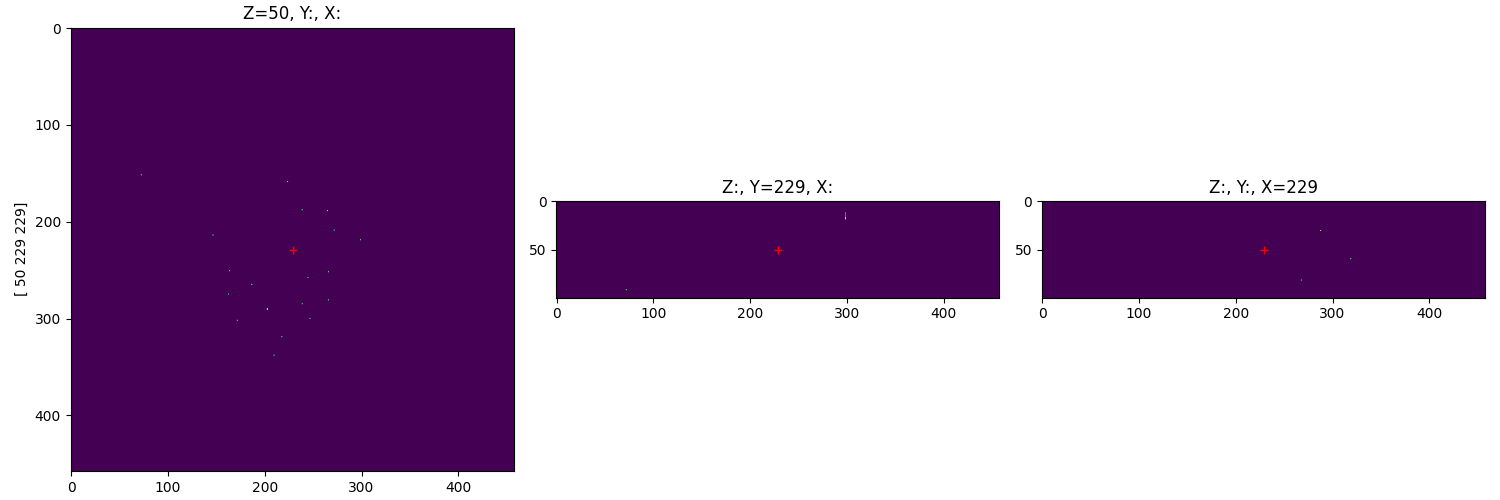

In [28]:
## VIS -> DCA
# from numba import jit, njit

# %matplotlib ipympl
%matplotlib qt
plt.ion()

view_dsa_l = [
    # xh(ddsac_mca.astype(np.uint8)),
    # dblock,
    # dsa, #[tuple(slice(s//5, (4*s)//5) for s in dsa.shape)]//(4096/256), 
    # d, #sc[tuple(slice(s//5, (4*s)//5) for s in dsa.shape)]//(4096/256),
    # dsa_amp_pl[1], #[tuple(slice(s//5, (4*s)//5) for s in dsa.shape)]//(4096/256),
    # dsa_arc_pl[1]
    xh(circ_filteredout)
]
view_center_axes_names = "ZYX"
view_slice_axes = ((1, 2), (0, 2), (0, 1))  # common for v_dsa
view_center_l = [np.asarray(dsax.shape) //2 for dsax in view_dsa_l]

figsize = 5
vfig_res = (view_dsa_l.__len__(), view_slice_axes.__len__())
vfig, vax_l = plt.subplots(
    *vfig_res,
    figsize=[figsize*vfr for vfr in vfig_res[::-1]])
if vax_l.shape.__len__() == 1:
    vax_l = vax_l[None, ...]

vai_l = np.zeros(vax_l.shape, dtype=list)
for vdsa_ix, vdsa in enumerate(view_dsa_l):
    for vsx_ix, vsxx in enumerate(view_slice_axes):
        vaxx = vax_l[vdsa_ix][vsx_ix]
        blank_im = np.zeros(
            (vdsa.shape[vsxx[0]], vdsa.shape[vsxx[1]]),
            dtype = vdsa.dtype)
        blank_im[0, 0] = vdsa.max()
        axis_image = vaxx.imshow(blank_im)#, cmap='gray')
        axis_center = vaxx.plot([0], [0], marker='+', c='r')
        axis_title = vaxx.set_title("")
        axis_ylabel = vaxx.set_ylabel("")
        
        vai_l[vdsa_ix][vsx_ix] = [
            axis_image,
            axis_center[0],
            axis_title,
            axis_ylabel,
        ]

# @jit(nopython=False)
def update_dsa_view(vdsa_ix):
    vai = vai_l[vdsa_ix]
    vsx = view_slice_axes
    vce = view_center_l[vdsa_ix]
    vdsa = view_dsa_l[vdsa_ix]

    for axex, axes in enumerate(vsx):
        indices = tuple((vce[axix] if axix not in axes else slice(None)) 
            for axix in range(vce.__len__()))
        sliced = vdsa[indices] # if axes[0] < axes[1] else vdsa[indices].T
        # print(vax[axex].imshow(sliced))
        vai[axex][0].set_data(sliced)

        slice_center = ([vce[axes[1]]], [vce[axes[0]]])
        vai[axex][1].set_data(*slice_center)

        indices_str = ", ".join(tuple(f"{axix_name}={vce[axix]}" if axix not in axes else f"{axix_name}:" 
            for axix, axix_name in enumerate(view_center_axes_names)))
        vai[axex][2].set_text(indices_str)

    vai[0][3].set_text(str(vce))
    vfig.canvas.draw()
    # vfig.canvas.flush_events()
    # plt.gcf().canvas.draw()

def update_center(vdsa_ix, vax_ix, xy_center):
    view_center = view_center_l[vdsa_ix]
    slice_axes_updated = view_slice_axes[vax_ix]
    view_center[slice_axes_updated[0]] = xy_center[1]
    view_center[slice_axes_updated[1]] = xy_center[0]

def mouse_callback(event):
    on_canvas = event.inaxes is not None
    xy = (int(event.xdata), int(event.ydata)) if on_canvas else (None, None)
    vdsa_ix, vax_ix = np.argwhere(vax_l == event.inaxes)[0] if on_canvas else (None, None)
    button, dc = (int(event.button), event.dblclick)
    # print(event)
    # print(on_canvas, xy, (vdsa_ix, vax_ix), (button, dc))

    if on_canvas:
        if button == 1:
            update_center(vdsa_ix, vax_ix, xy)
            update_dsa_view(vdsa_ix)
        elif button == 3:
            for vdsa_ix in range(view_dsa_l.__len__()):
                update_center(vdsa_ix, vax_ix, xy)
                update_dsa_view(vdsa_ix)

for vdsa_ix in range(view_dsa_l.__len__()):
    update_dsa_view(vdsa_ix)

cid = vfig.canvas.mpl_connect('button_press_event', mouse_callback)
vfig.tight_layout()
# vfig.canvas.draw()

In [11]:
## CODE > CIRCULAR SEGMENTATION > VIEW 2D
%matplotlib ipympl

proc_dtype  = xp.float16
radii_dtype = xp.float16
score_dtype = xp.float16
xd, xh, xa, xp              = xm[np]             

nxy = list(range(300, 500, 1))
# nxy = [0]
nn = nxy.__len__()

image_i = (dsa[nxy, ...]/(4096/256)).astype(np.uint8)
image_c = dsa_amp_pl[0, nxy, ...]
image_a = dsa_arc_pl[0, nxy, ...]
print(image_c.mean(axis=(1,2)))

mmclamm = 750
mm_clamp = (mmclamm, mmclamm+100)
image_c = np.clip((image_c-mm_clamp[0])/(mm_clamp[1]-mm_clamp[0]), 0, 1)

image_cd = xd(image_c).astype(proc_dtype)
image_ad = xd(image_a)

cc_mask_stddev = 3
cc_mask_step = 3
cc_mask_threshold = .5
cc_score_cutoff = .5
cc_radii_cutoff = 2.1
cc_range = (3, 22, cc_mask_step)
 
ccrrl = list([1, 2]) + list(range(*cc_range))
ccrrl = sorted(ccrrl)
assert any(crx < cc_radii_cutoff for crx in ccrrl)

nd_2d2z = (*AXNEW, *AXALL, *AXALL)
if True:
    pad_cc_radius = ceil(max(ccrrl) + (cc_mask_stddev*2))
    pad_ms_radius = ceil(max(ccrrl))
    pad_ms_1d  = (pad_ms_radius,) *2
    pad = (*AXALL, slice(pad_cc_radius, image_c.shape[1]-pad_cc_radius), slice(pad_cc_radius, image_c.shape[2]-pad_cc_radius))

    sh_padded = image_c.shape
    sh_unpadd = tuple(na(sh_padded) - na([0,1,1])*2*pad_cc_radius)
    sh_mspadd = tuple(na(sh_unpadd) + na([0,1,1])*2*pad_ms_radius)

    pad_ms_mxa = xp.mgrid[(slice(-pad_ms_radius, pad_ms_radius+1),)*2].astype(index_dtype)
    pad_ms_amp = xp.sqrt((pad_ms_mxa.astype(radii_dtype)**2).sum(axis=0))
    pad_ms_mask = (pad_ms_amp <= pad_ms_radius) * (pad_ms_amp > 0)
    iter_adjmax_mask = tuple((pad_ms_amp[nd_2d2z][kernel_ixt], patch_sxt) for kernel_ixt, patch_sxt in kernel_apply(sh_mspadd, pad_ms_mask[(*AXNEW,)])[-1])

    pad_cc_mxa = xp.mgrid[(slice(-pad_cc_radius, pad_cc_radius+1),)*2].astype(index_dtype)
    pad_cc_amp = xp.sqrt((pad_cc_mxa.astype(radii_dtype)**2).sum(axis=0))
    pad_cc_arc = xp.arctan2(pad_cc_mxa[1], pad_cc_mxa[0])

circ_gen = []
for ixcr, ccrr in enumerate(ccrrl):
    cc_mask_stddev = cc_mask_stddev 
    ccr_rim = ccrr
    cc_divs = ccr_rim*2

    cc_mask = xp.exp(-((pad_cc_amp-ccr_rim)/cc_mask_stddev)**2)
    cc_mask[cc_mask < cc_mask_threshold] = 0
    cc_mask /= (cc_divs)

    cc_mask_d = cc_mask[nd_2d2z]

    cc_arc_discr = (2*xp.pi)/cc_divs
    cc_mask_arc_discr = xp.floor((pad_cc_arc[nd_2d2z]/cc_arc_discr))
    # cc_mask_arc = ((cc_mask_arc_discr+.5)*cc_arc_discr)

    iter_ccmask_rad = tuple((
            (cc_discr+.5)*cc_arc_discr,
            tuple((
                tuple(kernel_ixt),
                tuple(slice(kix, asx + kix) for kix, asx in zip(kernel_ixt, sh_unpadd)),
            ) for kernel_ixt in xa(xp.where((cc_mask_d!=0)*(cc_mask_arc_discr==cc_discr))).astype(index_dtype).T))
        for cc_discr in range(-cc_divs//2, cc_divs//2+1))
    circ_gen.append((cc_mask_d, ccr_rim, iter_ccmask_rad))
print("INIT_DONE")

circ_score = xp.zeros(sh_unpadd, dtype=xp.float16)
circ_scsum = xp.zeros(sh_unpadd, dtype=xp.float16)
circ_radii = xp.zeros(sh_unpadd, dtype=xp.float16)

for (cc_mask_d, ccr_rim, iter_ccmask_rad,) in circ_gen:
    pdop_ccmask_rad = xp.zeros(sh_unpadd, dtype=proc_dtype)
    for kernel_arc, iter_ccmask in iter_ccmask_rad:
        pdop_ccmask_ri = xp.zeros(sh_unpadd, dtype=proc_dtype)
        image_adr = xp.cos(image_ad-kernel_arc)**8
        for kernel_ixt, patch_sxt, in iter_ccmask: 
            pcat = image_adr[patch_sxt]
            pccm = image_cd[patch_sxt] * cc_mask_d[kernel_ixt] * pcat
            pdop_ccmask_ri = xp.maximum(pdop_ccmask_ri, pccm)
        pdop_ccmask_rad += pdop_ccmask_ri

    circ_score_recalc = pdop_ccmask_rad 
    ccovsc_bxa = (circ_score < circ_score_recalc)
    circ_radii = np.where(ccovsc_bxa, ccr_rim,              circ_radii)
    circ_score = np.where(ccovsc_bxa, circ_score_recalc,    circ_score)
    circ_scsum += pdop_ccmask_rad#

mspad = ((0,)*2, pad_ms_1d, pad_ms_1d,)
circ_scsum_pd = xp.pad(circ_score, mspad, constant_values=0)
circ_score_pd = xp.pad(circ_score, mspad, constant_values=0)
circ_radii_pd = xp.pad(circ_radii, mspad, constant_values=0)

ccscore_redux =  (cc_radii_cutoff <= circ_radii) * (cc_score_cutoff <= circ_score)
ccscore_redux_pd = xp.pad(ccscore_redux, mspad, constant_values=0)

ms_radii = xp.zeros(sh_unpadd, dtype=radii_dtype) + (circ_radii * ccscore_redux)
for kernel_rad, patch_sxt in iter_adjmax_mask: 
    ms_condi = (True
        * ccscore_redux_pd[patch_sxt] 
        * (circ_radii_pd[patch_sxt] + kernel_rad > circ_radii)
    )
    ms_radii += ms_condi * (1/(2*xp.pi*kernel_rad))
ms_radii_pd = xp.pad(ms_radii, mspad, constant_values=0)

circ_filteredout = xp.ones(sh_unpadd, dtype=proc_dtype) * ccscore_redux
for kernel_rad, patch_sxt in iter_adjmax_mask: 
    circ_filteredout *= (False
        + (ms_radii_pd[patch_sxt] <= ms_radii) # ms circ bigger
        + (circ_radii_pd[patch_sxt] <= circ_radii*0 + kernel_rad) #ms circ or lesser and out of range
    )

circ_radii_ = circ_radii
ccscore_redux = circ_filteredout
circ_radii_ = ms_radii


print("CALC_DONE")

#####
c_where = xp.where(ccscore_redux)
c_shift = c_where[0].shape[0]
circ_where_cc_ = xa(c_where).T
circ_score_cc_ = circ_score[c_where]
circ_radii_cc_ = circ_radii_[c_where]

axx = (nn, 4)
# axx = (2, 4)
fig, ax = plt.subplots(*axx, figsize=4*na(axx[::-1]))
if ax.shape.__len__()==1: ax = na([ax])
fig.tight_layout()


#####
"""
ax[1, 2].imshow(xh((ms_radii-circ_radii)[0]))
ax[1, 3].imshow(xh((ms_radii)[0]))

ax[1, 0].imshow(xh(circ_score[0]))
# ax[1, 2].imshow(xh((circ_score * (circ_radii > cc_radii_cutoff))[0]))
ax[1, 1].imshow(xh(circ_radii[0]))
# ax[1, 3].imshow(xh((circ_radii * (circ_score > cc_score_cutoff))[0]))

withcircles = image_i[(slice(None), *pad[1:])].copy()
withdots = image_i[(slice(None), *pad[1:])].copy()
for nnx in range(1):
    dicsriminator = circ_where_cc_[:, 0] == nnx
    circ_where_cc = circ_where_cc_[dicsriminator, 1:]
    circ_radii_cc = circ_radii_cc_[dicsriminator]
    circ_score_cc = circ_score_cc_[dicsriminator]
    print("mean score hist:", np.histogram(xh(circ_score_cc)))

    for ci, cw, cr in zip(circ_score_cc, circ_where_cc, circ_radii_cc): 
        cv2.circle(withcircles[nnx], xh(cw[::-1]), int(cr), color=4000, thickness=1)
        withdots[(nnx, *xh(cw))] = 4000

    ax[nnx, 0].imshow(withcircles[nnx])
    ax[nnx, 1].imshow(withdots[nnx])
    ax[nnx, 2].imshow(image_c[nnx][pad[1:]])
    # ax[nnx, 3].imshow(xh(pdop_adjmax_cent[nnx][pad[1:]]))
    ax[nnx, 3].imshow(image_a[nnx][pad[1:]])
    # ax[2, 3].imshow(image_a[nnx][pad[1:]])
"""
#####
withcircles = image_i[(slice(None), *pad[1:])].copy()
withdots = image_i[(slice(None), *pad[1:])].copy()
for nnx, _ in enumerate(nxy):
    # if nnx == 0: continue
    dicsriminator = circ_where_cc_[:, 0] == nnx
    print(nnx, xh(dicsriminator).sum())
    circ_where_cc = circ_where_cc_[dicsriminator, 1:]
    circ_radii_cc = circ_radii_cc_[dicsriminator]
    circ_score_cc = circ_score_cc_[dicsriminator]
    # print("mean score hist:", np.histogram(xh(circ_score_cc)))

    for ci, cw, cr in zip(circ_score_cc, circ_where_cc, circ_radii_cc): 
        cv2.circle(withcircles[nnx], xh(cw[::-1]), int(cr), color=4000, thickness=1)
        withdots[(nnx, *xh(cw))] = 4000

    ax[nnx, 0].imshow(withcircles[nnx])
    ax[nnx, 1].imshow(withdots[nnx])
    ax[nnx, 2].imshow(image_c[nnx][pad[1:]])
    # ax[nnx, 3].imshow(xh(pdop_adjmax_cent[nnx][pad[1:]]))
    ax[nnx, 3].imshow(image_a[nnx][pad[1:]])

###
def mouse_callback(event):
    if int(event.button) ==3: print("marked: ", end="")
    on_canvas = event.inaxes is not None
    xy = (int(event.xdata), int(event.ydata)) if on_canvas else (None, None)
    print(xy, circ_scsum[0][xy[::-1]], circ_score[0][xy[::-1]], circ_radii[0][xy[::-1]]) #, eeee[xy[::-1]]) #, pdop_ccmask[xy[::-1]])
    if int(event.button) ==3:
        for axi in ax.flatten():
            axi.scatter(*xy, c='r', marker='+')
cid = fig.canvas.mpl_connect('button_press_event', mouse_callback)


[242.9 242.6 242.8 243.9 244.  244.4 246.4 246.8 247.8 248.5 250.4 251.6
 253.  253.  254.8 255.6 257.  258.2 262.  263.5 265.2 267.2 269.8 271.8
 273.  274.5 275.8 277.2 277.8 278.2 279.5 281.  282.8 284.2 290.2 297.
 304.5 311.8 318.8 324.2 329.2 332.8 340.2 344.2 349.2 352.8 354.  357.
 361.8 364.2 367.5 368.  370.2 369.  368.8 367.8 364.8 365.  361.5 358.
 357.2 354.2 353.  350.5 349.  349.  346.5 345.8 345.5 346.8 346.  349.
 350.5 353.8 354.2 354.  354.  357.5 360.  365.2 366.5 367.  369.2 370.8
 374.  378.  381.8 386.8 390.2 389.5 394.2 396.  398.5 404.5 403.5 405.2
 405.  406.5 407.5 405.2 403.5 400.  400.2 400.8 400.8 403.2 404.8 407.
 407.8 408.5 409.  409.  411.2 413.2 415.5 418.  418.5 420.2 418.5 419.2
 418.  418.8 415.  417.8 418.5 419.2 421.5 422.8 427.2 428.8 432.  434.8
 441.8 446.2 449.8 454.8 458.  463.2 464.8 467.2 470.8 473.2 474.8 480.8
 484.2 486.2 490.2 490.8 490.2 489.  486.2 485.2 485.  483.5 483.  480.8
 479.5 477.  474.5 469.5 466.  463.  460.  458.5 457.  4

KeyboardInterrupt: 

In [ ]:
## DATA READ > DYNAMIC

%matplotlib inline
xd, xh, xa, xp              = xm[cp]             
yd, yh, ya, yp              = xm[cp]

try: print(xp.zeros(0).device)
except BaseException: print("CPU!")

bnd2exc                 = na([[-1], [ 1]])

ds_ll = ds_l[:]
dslice_buffer           = (ds for ds in ds_ll)
def dslice_buffer2(n=9999):
    _ds_l = ds_ll
    splitn = np.random.randint(_ds_l.__len__()//32) *32
    print("Random dslice no = {}".format(splitn))
    ds_l2 = [*_ds_l[splitn:], *_ds_l[splitn:]]
    for ds in ds_l2[:n]:
        yield ds

corners_2d              = na(np.meshgrid(*(((0, 1),) *2))).reshape((2, -1)).T                   # [[0,0],[0,1],[1,0],[1,1]]
corners_3d              = na(np.meshgrid(*(((0, 1),) *3))).reshape((3, -1)).T                   # aa/3d
d_corners_2d            = xd(corners_2d)
d_corners_3d            = xd(corners_3d)

euler_to_matrix_rad = lambda roll_rad, pitch_rad, yaw_rad: np.array([
    [np.cos(yaw_rad) * np.cos(pitch_rad), -np.sin(yaw_rad) * np.cos(roll_rad) + np.cos(yaw_rad) * np.sin(pitch_rad) * np.sin(roll_rad), np.sin(yaw_rad) * np.sin(roll_rad) + np.cos(yaw_rad) * np.sin(pitch_rad) * np.cos(roll_rad)],
    [np.sin(yaw_rad) * np.cos(pitch_rad), np.cos(yaw_rad) * np.cos(roll_rad) + np.sin(yaw_rad) * np.sin(pitch_rad) * np.sin(roll_rad), -np.cos(yaw_rad) * np.sin(roll_rad) + np.sin(yaw_rad) * np.sin(pitch_rad) * np.cos(roll_rad)],
    [-np.sin(pitch_rad), np.cos(pitch_rad) * np.sin(roll_rad), np.cos(pitch_rad) * np.cos(roll_rad)]
])
euler_to_matrix_deg = lambda roll, pitch, yaw: np.array([
    [np.cos(np.radians(yaw)) * np.cos(np.radians(pitch)), -np.sin(np.radians(yaw)) * np.cos(np.radians(roll)) + np.cos(np.radians(yaw)) * np.sin(np.radians(pitch)) * np.sin(np.radians(roll)), np.sin(np.radians(yaw)) * np.sin(np.radians(roll)) + np.cos(np.radians(yaw)) * np.sin(np.radians(pitch)) * np.cos(np.radians(roll))],
    [np.sin(np.radians(yaw)) * np.cos(np.radians(pitch)), np.cos(np.radians(yaw)) * np.cos(np.radians(roll)) + np.sin(np.radians(yaw)) * np.sin(np.radians(pitch)) * np.sin(np.radians(roll)), -np.cos(np.radians(yaw)) * np.sin(np.radians(roll)) + np.sin(np.radians(yaw)) * np.sin(np.radians(pitch)) * np.cos(np.radians(roll))],
    [-np.sin(np.radians(pitch)), np.cos(np.radians(pitch)) * np.sin(np.radians(roll)), np.cos(np.radians(pitch)) * np.cos(np.radians(roll))]
])

def timeit(gene=None, desc=None):
    gene = gene if gene else (None,)
    for x in gene:
        t = datetime.datetime.now()
        yield x
        if desc:
            print(desc, datetime.datetime.now() -t)

""" spatial types:
# type          applies to      subtypes    dimensional ref
# spatial       db              sp, res     s
# chunk         dc                          c
# cgrid         db                          g           -dimissed
# planar        ds, dp          sh          p
# quantified                    sh, ix      -
"""

ndim                    = 3
dblock_resolution_mm    = (1,)     *ndim                                                        ## [mm] s{x,y,z}
dblock_chunk_shape      = (8,)     *ndim                                                        ## [ix] s{x,y,z}   

proc_dtype              = np.int16
meas_dtype              = np.float16
index_dtype             = np.int16

interp_max_dist         = 2                                                                     ## [mm]
continous               = True                                                                  # interpolate beetwen consecutive slices
adjust                  = True                                                                  # ... dblock space

## dblock > volumetric parametrization
if True:
    db_res                  = na(dblock_resolution_mm,                          dtype=meas_dtype)
    dc_sh                   = na(dblock_chunk_shape)                                                            
    dc_sp                   = db_res * dc_sh                                                                    # = spatial volume

    ddc_sp                  = xa(dc_sp)         
    ddc_sh                  = xa(dc_sh)
    ddc_mpa                 = xp.mgrid[tuple(slice(0, spx, res) for spx, res    in zip(dc_sp, db_res))  ]
    ddc_mxa                 = xp.mgrid[tuple(slice(0, shx)      for shx         in dc_sh)               ]

## dslice > init for CONSTANT parameters and dblock init      
# gene                    = (ds for ds in dslice_buffer2(200))               
gene                    = (dslice_buffer2(1))    ## DISABLE EXECUTION
if True:
    _dslice                 = gene.__next__()           
    ds_res                  = na(_dslice.PixelSpacing,                          dtype=meas_dtype)               ## [mm] p{x,y}
    dds_res                 = xd(ds_res,                                        dtype=meas_dtype)
    ds_sh                   = na(_dslice.pixel_array.shape) #//2 # dg            
    ds_sp                   = ds_sh * ds_res            

    _ds_thickness           = na(_dslice.SliceThickness,                        dtype=meas_dtype)               ## [mm] sz?
    ds2b_res                = (1/db_res) * ds_res[:, None]                                                      ## [ix/ix]  {p{x,y} / s{x,y,z}}
    ds_corners_sp           = corners_2d * ds_sp            

## dblock > init            
_db_init_pos            = na(_dslice.ImagePositionPatient,                  dtype=meas_dtype) #- interp_max_dist ## [mm] s{x,y,z}
_db_init_shape          = (0,) *ndim            

dblock_rev              = np.diag((1,) *ndim, 0)                                                            # SI:DBREV
db_spb                  = na((_db_init_pos,) *2)                                                            # {{l,u} * {x,y,z}}; spatial boundaries (upper one is cache by db_sh)
dblock                  = np.zeros(_db_init_shape,                          dtype=proc_dtype)               ## {s{x,y,z}}

assert np.all(dblock_rev == np.diag((1,) *ndim, 0))                                                         # simplicity issue SI:DBERV: using basic base to reduce (& implementing) adjustment revs
db_utrack               = np.zeros(_db_init_shape,                          dtype=meas_dtype)               # tracking updates timing via .AcquisitionTime # todo
db_sh                   = None

## save previous slice vals for interpolation update (atm allowing losing init dslice)  # todo: fulfill saving specified vals in loop
force_adjust            = True
interpolable            = False                                                                 # flag for dp info completeness

# for dslice in gene:
for dslice in timeit(gene, "cycle"):
    ## calc     > dslice properties
    if True:
        ds_array            = na(dslice.pixel_array,                        dtype=proc_dtype)

        ## calc dslice properties  @(abs)
        _ds2a_pos           = na(dslice.ImagePositionPatient,               dtype=meas_dtype)                   ## [mm] s{x|y|z}
        _ds2a_p2s           = na(dslice.ImageOrientationPatient,            dtype=meas_dtype).reshape((2, 3))   ## [1]  p{x2s{x|y|z} | y2s{x|y|z}}
        _ds_pos_a0          = _ds2a_pos                                     @ dblock_rev.T
        ds_p2s              = _ds2a_p2s                                     @ dblock_rev.T
        # ds_p2s = ds_p2s @ euler_to_matrix_deg(0,45,45) # dg
        ds_normal           = np.cross(*ds_p2s)                                                     # always unit vec (p2s components always stereometrically perpendicular)
        ds_rev              = na((*ds_p2s, ds_normal))                                              # rotation matrix
        ds_midb             = np.abs(interp_max_dist * ds_normal) * bnd2exc                         # maximal interpolation distance boundaries

        ## calc dslice properties   > calc excess, adjust dblock  @(db_pos, db_rev)
        _ds_spb_a0          = np.matmul(ds_corners_sp, ds_p2s) + _ds_pos_a0
        _ds_spb_abs         = na((  _ds_spb_a0.min(axis=0), 
                                    _ds_spb_a0.max(axis=0),))
        _ds_spb_ext_abs     = _ds_spb_abs + ds_midb                                                                        

        ds_sp_exc           = np.maximum((_ds_spb_ext_abs - db_spb) *bnd2exc, 0)                    ## {{l|r}, {x|y|z}} spatial excess over dblock; SI: is extended for roi crop for interpolation (to dimiss minmaxing for dblock boundaries)
        if (adjust and np.any(ds_sp_exc > 0)) or force_adjust:                                      # if dslice excesses beyond dblock
            print("dblock padded")
            _ds2c_shexc     = np.ceil(ds_sp_exc / dc_sp)                    .astype(index_dtype)    # pad with chunk shape
            _db_spbexc      = _ds2c_shexc * dc_sp
            _db_shbexc      = _ds2c_shexc * dc_sh

            db_spb          = db_spb + (_db_spbexc * bnd2exc)
            dblock          = np.pad(dblock,   _db_shbexc.T, "constant", constant_values=0)
            force_adjust    = False

        ds_spb              = _ds_spb_ext_abs   - db_spb[0]                                         # shift dslice position (after adjustment); operating in common spatial dimensions
        ds_pos              = _ds_pos_a0        - db_spb[0]

        ## calc dslice properties   > calc affected chunks region boundaries
        ds_scb              = ((ds_spb / dc_sp) + na([[0],[1]]))            .astype(index_dtype)
        ds_sx_rel           = ds_scb[1] - ds_scb[0]

        ## calc dslice properties   > to device
        dds_pos             = xd(ds_pos)
        dds_array           = xd(ds_array)
        dds_p2s             = xd(ds_p2s)
        dds_normal          = xd(ds_normal)
        dds_midb            = xd(ds_midb)
        dds_scb             = xd(ds_scb)

    ## qualify  > dslice    > chunks affected  @(ds_sc_pos, db_rev)
    if True:
        _dds_scb_mvpae      = xp.moveaxis(
                                xp.mgrid[tuple(
                                    slice(      spl, spu + res,     res) 
                                    for         spl, spu,           res in 
                                    np.vstack(  (ds_scb * dc_sp,    dc_sp)).T)
                                ].astype(meas_dtype), 
                                0, -1) - dds_pos  # device-data-slice_shape:chunk-boundaries_meshgrid-moveaxed-spatial-array-extended = spatial corners of chunks; intercept from eq: a*(x-x0) + b*(y-y0) + c(z-z0) = 0, yet adjusted to db[_sp_ogrid]
        _dds_scb_mxa_cr     = tuple(d_corners_3d.T[(..., *((None,)*ndim))] 
                                + xp.mgrid[tuple(slice(scb) for scb in ds_sx_rel)][:, None])        # {t:ndim, c{x,y,z}} => {t:ndim, cr=2**ndim, c{x,y,z}} - corners take
        
        _dds_scb_mpae_mddist= xa(tuple(xp.sum((_dds_scb_mvpae + dds_midbx) * dds_normal, axis=-1) for dds_midbx in dds_midb))
        _ddcc_planar        = xp.logical_or(
                                xp.mod((_dds_scb_mpae_mddist[0][_dds_scb_mxa_cr] > 0).sum(axis=0), d_corners_3d.__len__()),
                                xp.mod((_dds_scb_mpae_mddist[1][_dds_scb_mxa_cr] > 0).sum(axis=0), d_corners_3d.__len__()),)   # verify which chunk corners directed_distance values different signs = dslice+-imd*normal passes through them; assert (interp_max_dist << dc_sp <=> (ds passes chunk == chunk between dslice+-imd*normal) bcof this
        """
        t = datetime.datetime.now()
        _dds_scb_mxa_rel_cr = tuple(_dds_scb_mxa_rel[..., None] + d_corners_3d.T[(slice(None), *((None,) *ndim), slice(None))])
        ddcc_planar_         = xp.logical_or(
                                xp.mod((dds_scb_mpae_mddist[0][_dds_scb_mxa_rel_cr][..., None] > 0).sum(axis=-2), 2**ndim).squeeze(axis=-1),
                                xp.mod((dds_scb_mpae_mddist[1][_dds_scb_mxa_rel_cr][..., None] > 0).sum(axis=-2), 2**ndim).squeeze(axis=-1),)   
        print((datetime.datetime.now() - t)) 
        # t = datetime.datetime.now()
        # ddcc_planar_u       = xp.zeros((dds_midb.__len__(), *ds_sx_rel),                    dtype=index_dtype)
        # for dcr in d_corners_3d:
        #     ddcc_planar_u   += dds_scb_mpae_mddist[(slice(None),) + tuple(slice(dcx, scb + dcx) for scb, dcx in zip(ds_sx_rel, dcr))] > 0
        # ddcc_planar          = xp.logical_or(*xp.mod(ddcc_planar_u, d_corners_3d.__len__())) # use only with interp_max_dist << dc_sh  # print(ha(ddcc_planar).sum(), "/", np.prod(ds_sx_rel))
        # print((datetime.datetime.now() - t))
        # print((ha(ddcc_planar == ddcc_planar_)).all())
        """
        _dds_scb_mpae_dsproj= (tuple(xp.sum((_dds_scb_mvpae) * dds_p2sx, axis=-1) for dds_p2sx in dds_p2s))
        _ddcc_proj          = xa((  
                                0 <= _dds_scb_mpae_dsproj[0][_dds_scb_mxa_cr], _dds_scb_mpae_dsproj[0][_dds_scb_mxa_cr] <= ds_sp[0]-1,
                                0 <= _dds_scb_mpae_dsproj[1][_dds_scb_mxa_cr], _dds_scb_mpae_dsproj[1][_dds_scb_mxa_cr] <= ds_sp[1]-1,
                            )).all(axis=1).all(axis=0)  # Performance issue rel2aa [dc_proj_chunked]; alt: # 
                            # )).any(axis=1).all(axis=0)
        dds_ac_mca          = xp.logical_and(_ddcc_planar, _ddcc_proj)                                # device data chunk condition

    ## qualify  > dinterp   > chunks affected @(db_pos, db_rev) #todo: batchify?
    if interpolable:  # for _ in timeit("calc chunks cond"): # 0.286
        _ddiac_spb          = xa((  xp.maximum(ddp_scb[0], dds_scb[0]),
                                    xp.minimum(ddp_scb[1], dds_scb[1])))
        _ddiac_mca          = xp.logical_and(
                                dds_ac_mca[tuple(slice(scl, scu) for scl, scu in (_ddiac_spb - dds_scb[0]).T)],
                                ddp_ac_mca[tuple(slice(scl, scu) for scl, scu in (_ddiac_spb - ddp_scb[0]).T)],)
        ddiac_l             = _ddiac_spb[0] + xa(xp.where(_ddiac_mca)).T
        """ batchified
        # for _ , ddiabc_l in batchify(ddiac_l, patch_shape=dc_sh, umem_pool=2**31, umem_poly=(*(0,)*ndim, 600), tv=None, xp=xp):
        # for ddiabc_l in (ddiac_l.T,):
            # ddiac_lmvpa         = ((xa(ddiabc_l).T * ddc_sp)[(..., *(None,) *ndim)] + ddc_mpa).swapaxes(1, -1) ##{l, c{x,y,z}, ndim}; 
            # ddiac_lmxa          = ((xa(ddiabc_l).T * ddc_sh)[(..., *(None,) *ndim)] + ddc_mxa).swapaxes(0, 1)  ##{ndim, l, c{x,y,z}}
        """

        ddiac_lmvpa         = np.moveaxis((ddiac_l * ddc_sp)[(..., *(None,) *ndim)] + ddc_mpa, 1, -1) ##{l, c{x,y,z}, ndim}; 
        ddiac_lmxa          = np.moveaxis((ddiac_l * ddc_sh)[(..., *(None,) *ndim)] + ddc_mxa, 0, 1)  ##{ndim, l, c{x,y,z}}
        print("ddiac_lmvpa", ddiac_lmvpa.shape)
    
    ## qualify  > dinterp   > voxels
    if interpolable:
        _ddiac_mpa_mddist   = xa(tuple(
                                xp.sum((ddiac_lmvpa - ddi_pos) * ddi_normal, axis=-1) 
                                for ddi_normal, ddi_pos in ((ddp_normal, ddp_pos), (dds_normal, dds_pos))))
        _ddiac_mpa_madist   = xp.abs(_ddiac_mpa_mddist)
        assert xp.dot(ddp_normal, dds_normal) > 0
        _ddiac_planar       = xp.logical_and(
                                _ddiac_mpa_mddist[0] * _ddiac_mpa_mddist[1] <= 0,
                                _ddiac_mpa_madist[0] + _ddiac_mpa_madist[1] <= interp_max_dist)
        _dds_mpa_dsproj     = xa(tuple(tuple(
                                xp.sum((ddiac_lmvpa - ddi_pos) * ddi_p2s_x, axis=-1) 
                                for ddi_p2s_x in ddi_p2s)
                                for ddi_p2s, ddi_pos in ((ddp_p2s, ddp_pos), (dds_p2s, dds_pos))))  ## {{dp|ds}, ds{x|y}, l, sp{x,y,z}}
        _ddiac_proj         = xp.ones(_ddiac_planar.shape, dtype=bool)  # Performance issue ad:[dc_proj_chunked]; alt: 
        # _ddiac_proj         = xa((0 <= _dds_mpa_dsproj[:, 0], _dds_mpa_dsproj[:, 0] <= ds_sp[0]-1, 0 <= _dds_mpa_dsproj[:, 1], _dds_mpa_dsproj[:, 1] <= ds_sp[1]-1,)).all(axis=(0, 1))  # SI: assuming ds_sp is constant
        diac_cond           = xp.logical_and(_ddiac_planar, _ddiac_proj)

    ## calc     > dinterp   > voxels
    if interpolable:
        vxval               = xp.zeros(diac_cond.shape, dtype=proc_dtype)
        for dsix in (0,1):
            _dsar           = (ddp_array, dds_array)[dsix]
            _dsdw           = _ddiac_mpa_madist[dsix] / _ddiac_mpa_madist.sum(axis=0)
            _dspj           = _dds_mpa_dsproj[dsix]
            _dspj_f         = (_dspj / dds_res[(..., *(None,) * (ndim+1))]) ## {ds{x|y}, l, sp{x,y,z}}
            _dspj_i         = _dspj_f.astype(index_dtype)
            _dspj_r         = _dspj_f - _dspj_i

            _dspj_i_cr      =        d_corners_2d.T[(..., *(None,)*(ndim+1))] + _dspj_i[:, None]
            _dspj_r_cr      = xp.abs(d_corners_2d.T[(..., *(None,)*(ndim+1))] - _dspj_r[:, None])

            _vxvala         = (_dsar[tuple(_dspj_i_cr)] * _dspj_r_cr.prod(axis=0)).sum(axis=0) * _dsdw
            vxval           += (_vxvala).astype(proc_dtype)

        dblock[tuple(xh(ddiac_lmxa))] = np.where(xh(diac_cond), xh(vxval), dblock[tuple(xh(ddiac_lmxa))])
        # dblock[tuple(xh(ddiac_lmxa))] = np.where(xh(diac_cond), i, dblock[tuple(xh(ddiac_lmxa))])

    ## cache    > previous dslice
    if True:
        interpolable        = True
        ddp_array           = dds_array
        ddp_ac_mca          = dds_ac_mca
        ddp_normal          = dds_normal
        ddp_p2s             = dds_p2s
        ddp_scb             = dds_scb
        ddp_pos             = dds_pos


